In [1]:
from lstd import *
from q_learning import *
import numpy as np
from typing import List, Tuple
from utils import *
from itertools import product
from scipy.optimize import minimize

># Model Definition

In [2]:
THETA   = 1/2
KAPPA   = 1/2
OMEGA_A = 0.1
OMEGA_U = 0.1
GAMMA_U = 0.9
BETA_U  = 0.1 
BETA_A  = 0.1 
ALPHA_U = 1
SIGMA_D = 1
LAMBDA  = 1

In [3]:
A = np.array([
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 0, THETA, THETA - KAPPA],
        [0, 0, 0, 1 - OMEGA_A, 0],
        [0, 0, 0, 0, 1 - OMEGA_U]])
B = np.array([1, GAMMA_U, (THETA - KAPPA) * GAMMA_U, 0, OMEGA_U * BETA_U])

Sigma_x = np.array([
    [0, 0, 0, 0, 0], 
    [0, SIGMA_D**2, THETA*SIGMA_D**2, 0, 0],
    [0, THETA*SIGMA_D**2, THETA**2*SIGMA_D**2, 0, 0],
    [0, 0, 0, BETA_A**2, 0],
    [0, 0, 0, 0, 0]])

Q = np.array([
    [LAMBDA*SIGMA_D**2, 0, 0, -1/2, -1/2], 
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [-1/2, 0, 0, 0, 0],
    [-1/2, 0, 0, 0, 0]])
S = np.array([
    [LAMBDA*THETA*SIGMA_D**2 - GAMMA_U/2, 0, 0, -THETA/2, -(THETA - KAPPA)/2]])

R = np.array([[LAMBDA*THETA**2*SIGMA_D**2 - (THETA - KAPPA)*GAMMA_U]])
C = np.array([[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0]])
L = np.block([[Q, S.T], [S, R]])

We will re-utilize the LQR gain obtained previously

In [4]:
K_star = np.array([0.85724945,  0.,          0.,         -0.40135333, -0.38022947])

># Prerequisite

We first define the helper functions

In [5]:
def LQR_policy(x: np.ndarray) -> np.ndarray:
    return -K_star @ x

def phi_e(x : np.ndarray, sigma_e = 0.5) -> np.ndarray:
    return LQR_policy(x) + np.random.randn() * sigma_e

def psi_Q(x, u):

    if not np.isscalar(u):
        u = u[0]
        
    x1 = x[0]
    x4 = x[3]
    x5 = x[4]
    psi = [x1**2, x4**2, x5**2, u**2, x1*u, x4*u, x5*u,\
             x1*x4, x1*x5, x4*x5]

    return np.array(psi)

def policy_Q(x, theta):
    sum = theta[4]*x[0] + theta[5]*x[3] + theta[6]*x[4]
    return - sum / (2*theta[3])

In [6]:
def simulate_linear_model(x0: np.ndarray, policy : callable, n_step : int, with_noise : bool = False) -> Tuple[np.ndarray, np.ndarray]:

    x = np.zeros((5, n_step))
    u = np.zeros((1, n_step-1))

    x[:,0] = x0

    for i in range(n_step-1):

        u[:, i] = policy(x[:,i])
        
        if with_noise:
            x[:,i+1] = A @ x[:,i] + B * u[:, i] + np.random.multivariate_normal(np.zeros(5), Sigma_x)
        else:
            x[:,i+1] = A @ x[:,i] + B * u[:, i]

    return (x, u)


def simulate_nl_model(x0: np.ndarray, policy : callable, n_step : int, with_noise : bool = False, var = 1) -> Tuple[np.ndarray, np.ndarray]:

    x = np.zeros((5, n_step))
    u = np.zeros((1, n_step-1))

    x[:,0] = x0

    for i in range(n_step-1):

        I = x[0,i]
        x_a = x[3,i]
        x_u = x[4,i]

        # Control input based on the LQG controller
        u[:, i] = policy(x[:, i])
     
        # Update state 
        F = np.array([
            I + u[0, i],
            x_a + x_u + GAMMA_U* u[0, i] + ALPHA_U * u[0, i] * x_u,
            THETA * x_a + (THETA - KAPPA) * x_u + (THETA - KAPPA) * GAMMA_U * u[0, i] + (THETA - KAPPA) * ALPHA_U * u[0, i] * x_u,
            (1 - OMEGA_A) * x_a,
            (1 - OMEGA_U) * x_u + OMEGA_U * BETA_U * u[0, i]
        ])

        if with_noise:
            xi_d = np.random.normal(0, var)
            xi_a = np.random.normal(0, var)

            xi = np.array([0, SIGMA_D*xi_d, THETA*SIGMA_D*xi_d, BETA_A*xi_a, 0]).reshape(-1)

            x[:, i+1] = F + xi
        else:
            x[:, i+1] = F

    return (x, u)

># LSTD Method

## 1. Defining the basis functions and the cost function

In [7]:
def cost(x: np.ndarray, u: np.ndarray) -> float:
    if np.isscalar(u):
        u = np.array([u])
        
    return np.concatenate((x, u)) @ L @ np.concatenate((x, u))

## 2. Define the Q-function in the chosen basis $\psi$

In [8]:
# Q-function
Q_lstd = lambda x, u, theta, psi : psi(x, u) @ theta

## 3. Linear Model (without noise)

#### 3.1. TD for several W's

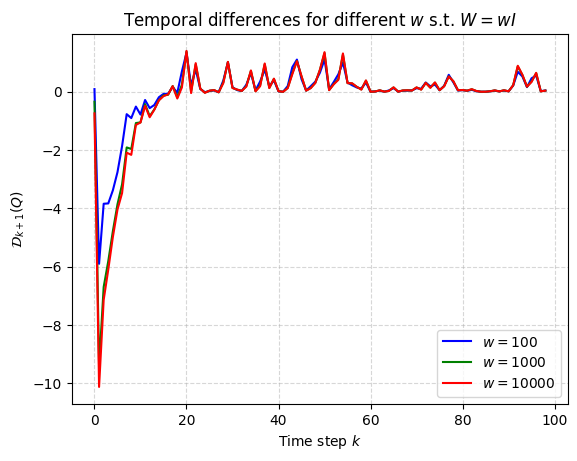

In [99]:
n_step = 100

x0 = [0, 2, 2, 2, 5]

psi = psi_Q
d = 10

phi = LQR_policy # policy used in the TD

data_linear = simulate_linear_model(x0, phi_e, n_step, with_noise=False)

val_W = np.array([100, 1000, 10000])
temporal_differences = np.zeros((len(val_W), n_step-1))
theta_lstd_lin_arr = np.zeros((len(val_W), d))

for i in range(len(val_W)):

    W = np.eye(d) * val_W[i]
    theta_lstd_lin = perform_lstd(phi, cost, psi, W, data=data_linear, d=d)
    theta_lstd_lin_arr[i] = theta_lstd_lin
    
    temporal_differences[i] = compute_TD(data_linear, Q_lstd, phi, cost, psi, theta_lstd_lin)

colors = ['b', 'g', 'r']

for i in range(len(val_W)):
    plt.plot(temporal_differences[i], color=colors[i], label='$w = $' + str(val_W[i]))
plt.legend()
plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
plt.title('Temporal differences for different $w$ s.t. $W=wI$')
plt.grid(linestyle='--', alpha = 0.5)
plt.show()

#### 3.2. TD for several initial conditions

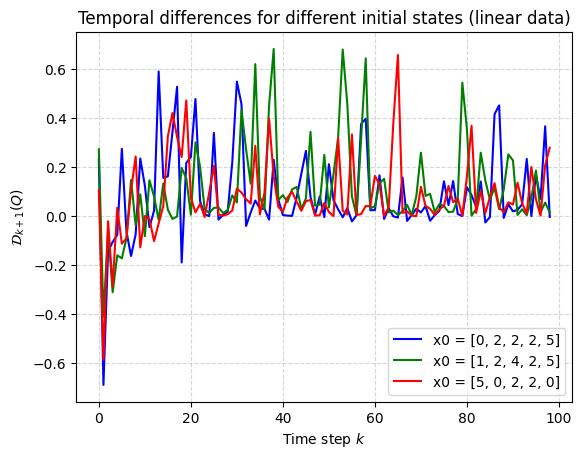

In [100]:
x0_arr = [[0, 2, 2, 2, 5], [1, 2, 4, 2, 5], [5, 0, 2, 2, 0]]

W = 1 * np.eye(d)
temporal_differences = np.zeros((len(x0_arr), n_step-1))

for i, x0 in enumerate(x0_arr):

    data_linear = simulate_linear_model(x0, phi_e, n_step, with_noise=False)
    theta_lstd_lin = perform_lstd(phi, cost, psi, W, data_linear, d)
    temporal_differences[i] = compute_TD(data_linear, Q_lstd, phi, cost, psi, theta_lstd_lin)

    
colors = ['b', 'g', 'r']
for i in range(len(x0_arr)):
    plt.plot(temporal_differences[i], color=colors[i], label='x0 = ' + str(x0_arr[i]))
plt.legend()
plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
plt.title('Temporal differences for different initial states (linear data)')
plt.grid(linestyle='--', alpha = 0.5)
plt.show()

### 3.3. TD for several $N$

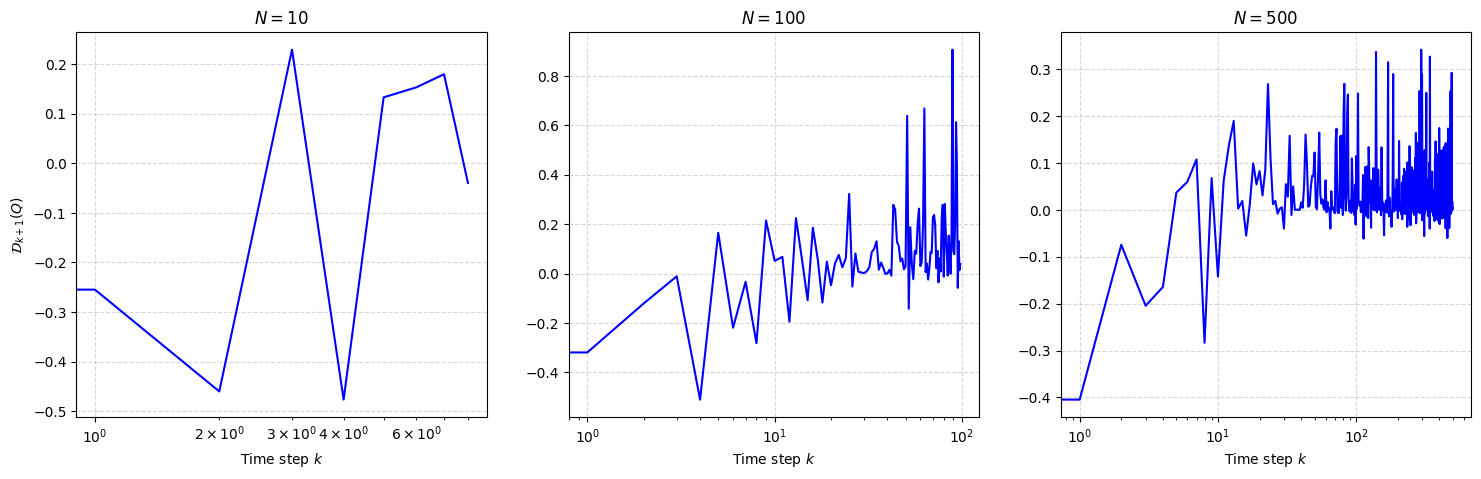

In [101]:
x0 = [0, 2, 2, 2, 5]
n_steps_arr = [10, 100, 500]
temporal_differences = []

for i, n_step in enumerate(n_steps_arr):

    data_linear = simulate_linear_model(x0, phi_e, n_step, with_noise=False)
    theta_lstd_lin = perform_lstd(phi, cost, psi, W, data_linear, d)
    td = np.zeros(n_step-1)

    TD = compute_TD(data_linear, Q_lstd, phi, cost, psi, theta_lstd_lin) 
    temporal_differences.append(TD)


fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i in range(len(n_steps_arr)):
    axs[i].semilogx(temporal_differences[i], color='b', label='n_step = ' + str(n_steps_arr[i]))
    axs[i].set_xlabel('Time step $k$')
    if i ==0:
        axs[i].set_ylabel('$\\mathcal{D}_{k+1}(Q)$')
    axs[i].grid(linestyle='--', alpha = 0.5)
    axs[i].set_title('$N=$' + str(n_steps_arr[i]))
#fig.suptitle('Temporal differences for different number of steps in the training data (linear data)')
# plt.savefig('temp_diff_n_steps_linear.pdf',dpi=300)
plt.show()

## 4. Nonlinear Model (without noise)

### 4.1. TDs

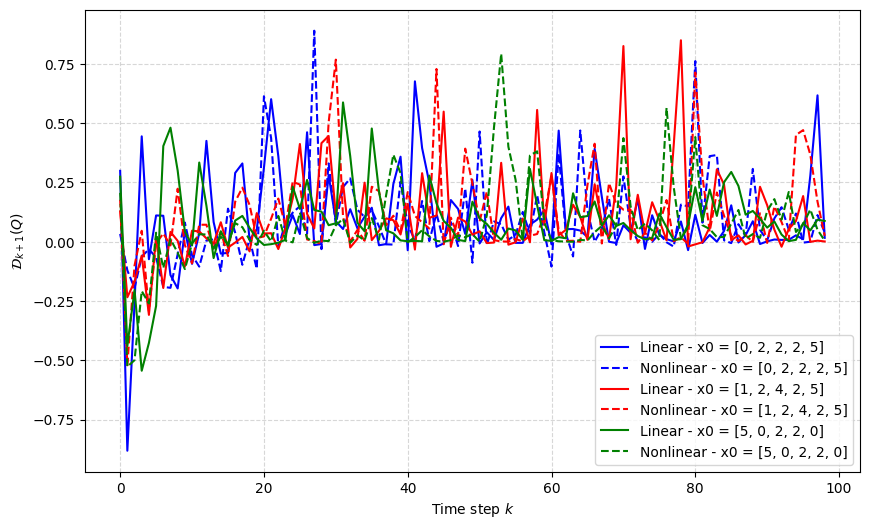

In [162]:
n_step = 100
x0_conditions = [[0, 2, 2, 2, 5], [1, 2, 4, 2, 5], [5, 0, 2, 2, 0]]
psi = psi_Q
d = 10
phi = LQR_policy
W = 1 * np.eye(d)

temporal_differences_lin = np.zeros((3, n_step - 1)) 
temporal_differences_nl = np.zeros((3, n_step - 1))

for i, x0 in enumerate(x0_conditions):
    # Simulate linear and nonlinear models for each initial condition
    data_nonlinear = simulate_nl_model(x0, phi_e, n_step, with_noise=False)
    data_linear = simulate_linear_model(x0, phi_e, n_step, with_noise=False)

    # Perform LSTD for both models
    theta_lstd_lin = perform_lstd(phi, cost, psi, W, data_linear, d)
    theta_lstd_nl = perform_lstd(phi, cost, psi, W, data_nonlinear, d)

    # Calculate temporal differences for linear and nonlinear models

    temporal_differences_lin[i] = compute_TD(data_linear, Q_lstd, phi, cost, psi, theta_lstd_lin)
    temporal_differences_nl[i] = compute_TD(data_nonlinear, Q_lstd, phi, cost, psi, theta_lstd_nl)


plt.figure(figsize=(10, 6))

colors = ['b', 'r','g']

for i in range(len(x0_conditions)):
    plt.plot(temporal_differences_lin[i,:], label='Linear - x0 = ' + str(x0_conditions[i]), color=colors[i], linestyle='-')
    plt.plot(temporal_differences_nl[i,:], label='Nonlinear - x0 = ' + str(x0_conditions[i]), color=colors[i], linestyle='--')

plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
#plt.title('Temporal differences for linear and nonlinear models')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.savefig('figures/temp_diff_linear_vs_nonlinear.pdf',dpi=300)
plt.show()


### 4.2. Using the Q-function to define policies

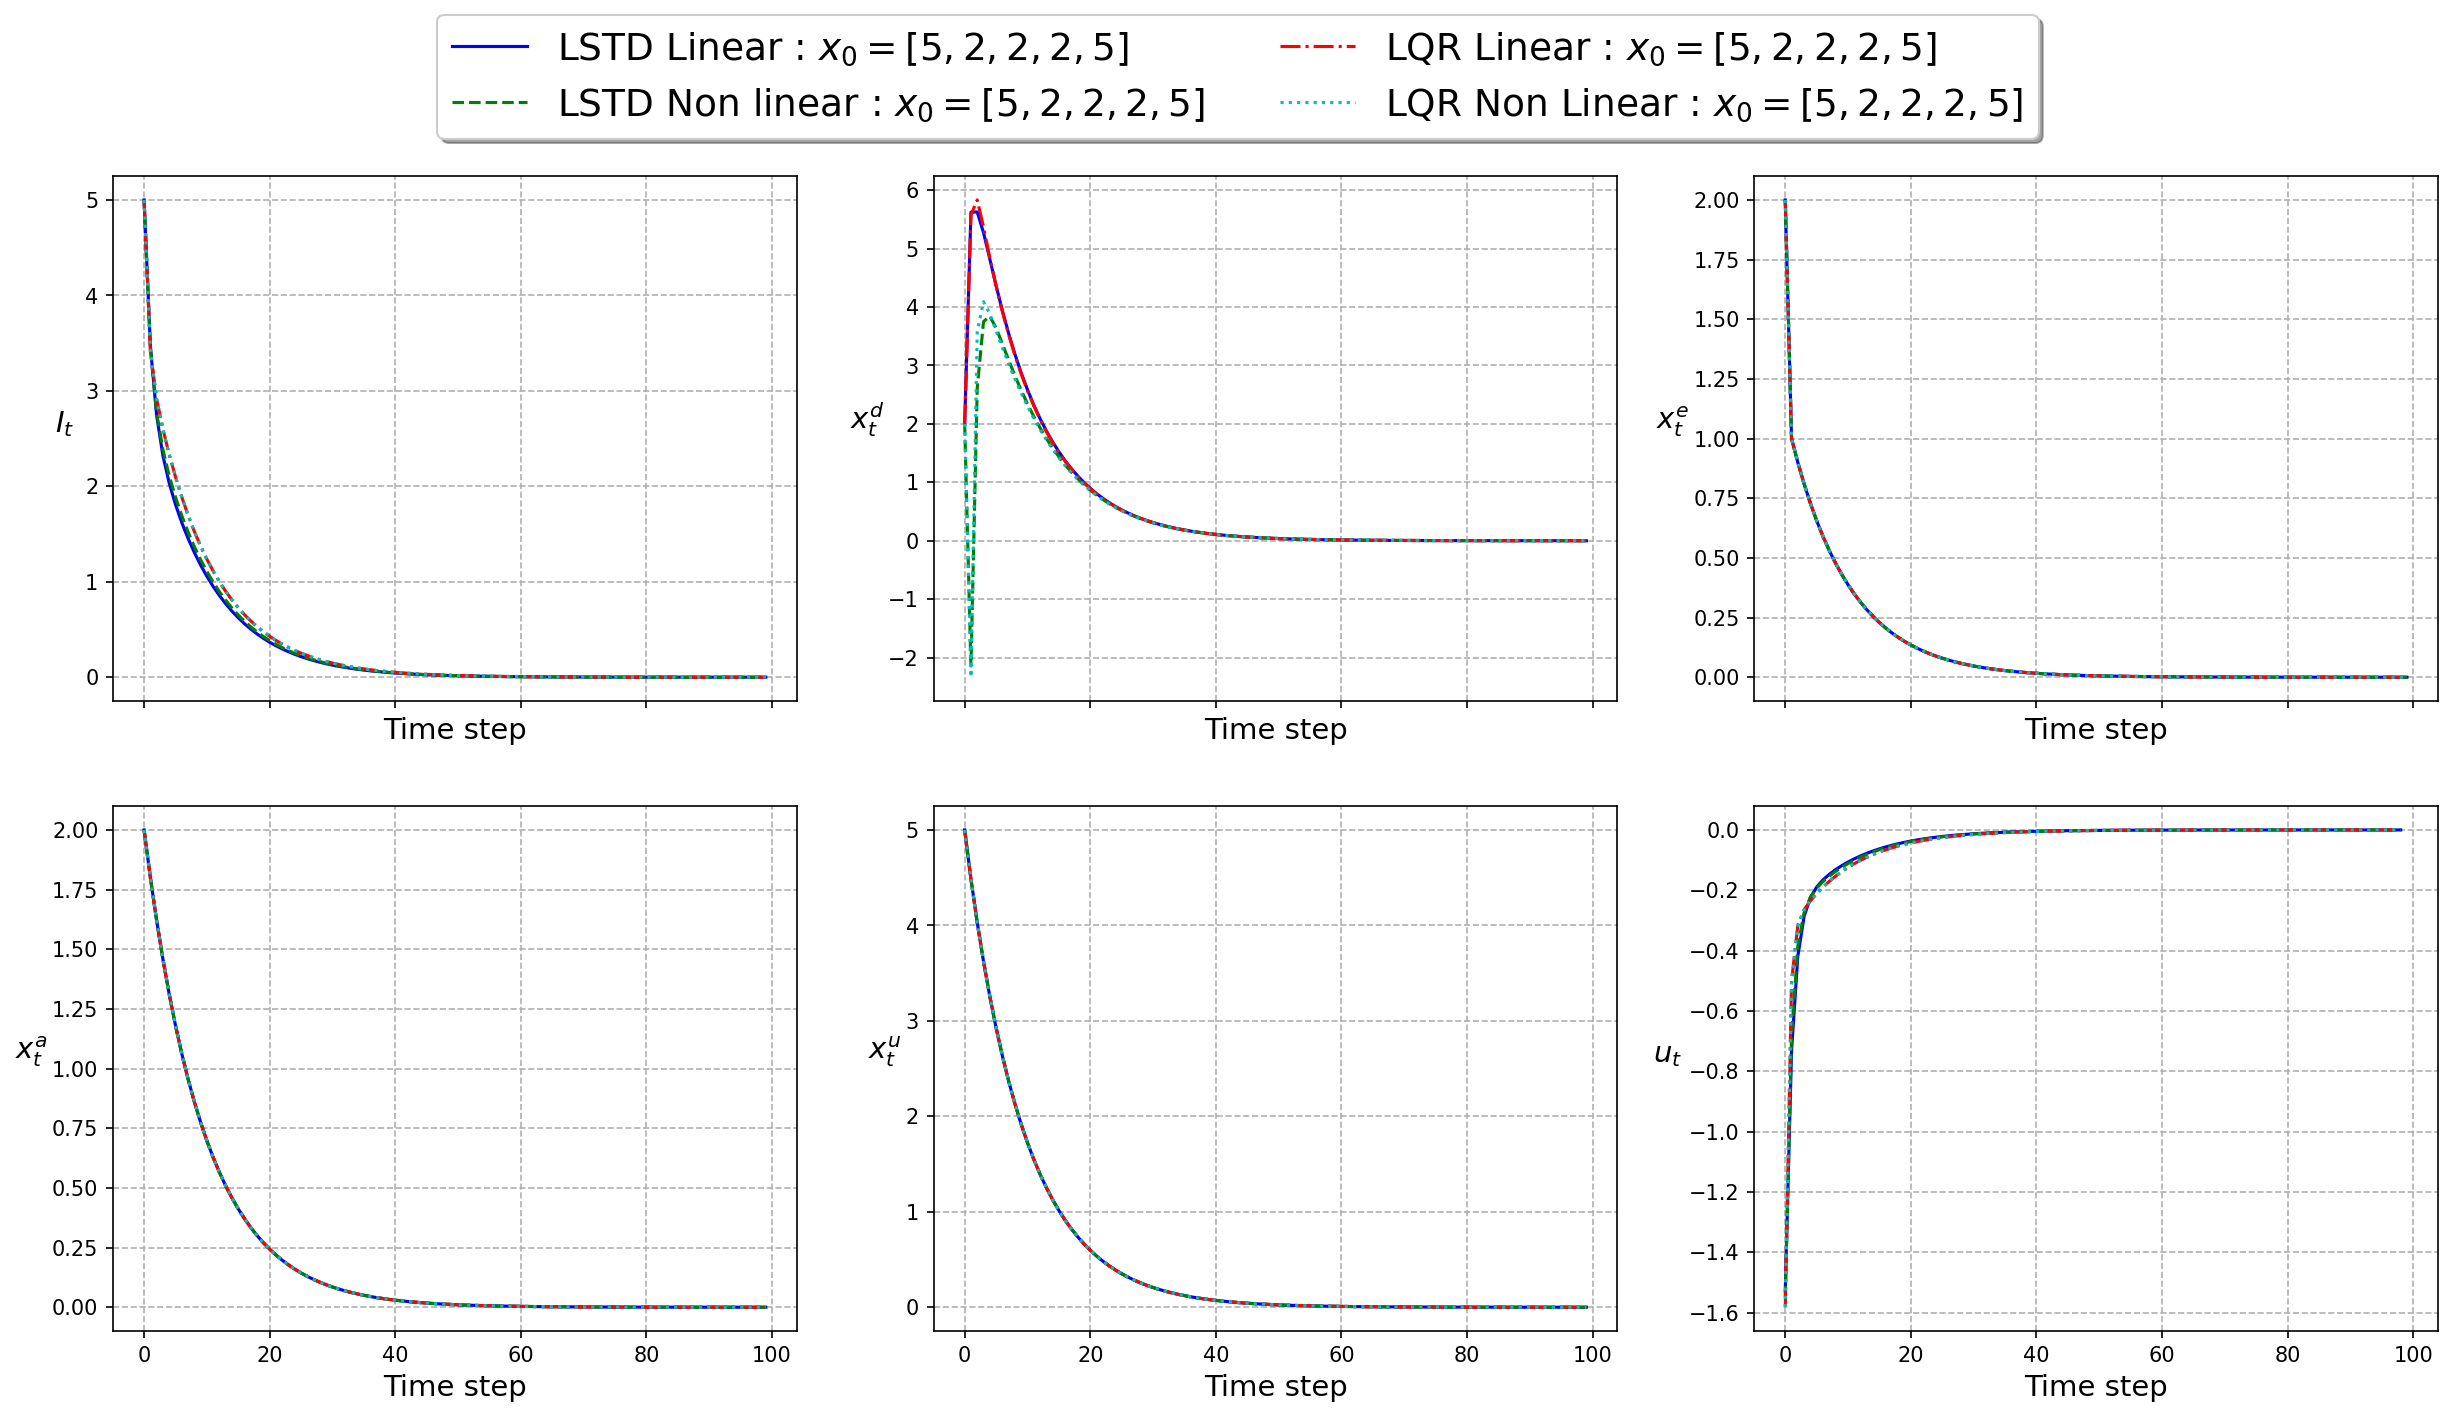

In [179]:
n_step = 100
phi = LQR_policy
psi = psi_Q

d = 10
W = 1 * np.eye(d)
x0 = [5, 2, 2, 2, 5]

data_nl = simulate_nl_model(x0, phi_e, n_step, with_noise=False)
data_linear = simulate_linear_model(x0, phi_e, n_step, with_noise=False)

theta_lstd_nl = perform_lstd(phi, cost, psi, W, data_nl, d=d)
theta_lstd_lin = perform_lstd(phi, cost, psi, W, data_linear, d=d)

def policy_lstd_lin(x: np.ndarray) -> np.ndarray:
    return policy_Q(x, theta_lstd_lin)

def policy_lstd_nl(x: np.ndarray) -> np.ndarray:
    return policy_Q(x, theta_lstd_nl)


x_lstd_lin, u_lstd_lin = simulate_linear_model(x0, policy_lstd_lin, n_step, with_noise=False)
x_lstd_nl, u_lstd_nl = simulate_nl_model(x0, policy_lstd_nl, n_step, with_noise=False)
x_lqr, u_lqr = simulate_linear_model(x0, LQR_policy, n_step, with_noise=False)
x_lqr_nonlin, u_lqr_nonlin = simulate_nl_model(x0, LQR_policy, n_step, with_noise=False)

show_trajectories([[x_lstd_lin], [x_lstd_nl], [x_lqr], [x_lqr_nonlin]], [[u_lstd_lin], [u_lstd_nl], [u_lqr], [u_lqr_nonlin]], [x0, x0,x0, x0], ['LSTD Linear',"LSTD Non linear", 'LQR Linear', "LQR Non Linear"], save = "traj_lstd_lin_nonlin.pdf")

## 5. Nonlinear Model (with noise)

### 5.1. Temporal Differences

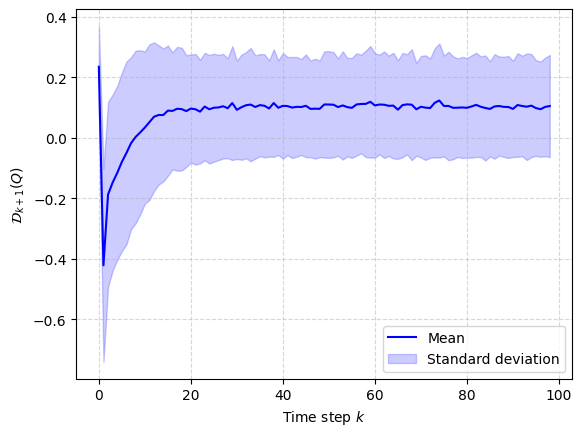

In [105]:
n_step = 100
x0 = [0, 2, 2, 2, 5]
n_simu = 1000
temporal_differences = np.zeros((n_simu, n_step-1))
d = 10
W = 1 * np.eye(d)
psi = psi_Q

for i in range(n_simu):
    data_nonlinear = simulate_nl_model(x0, phi_e, n_step, with_noise=True)
    theta_lstd_nl = perform_lstd(LQR_policy, cost, psi, W, data=data_nonlinear, d=d)

    temporal_differences[i] = compute_TD(data_nonlinear, Q_lstd, LQR_policy, cost, psi, theta_lstd_nl)
    
plt.plot(np.mean(temporal_differences, axis=0), color='b', label = 'Mean')
plt.fill_between(range(n_step-1), np.mean(temporal_differences, axis=0) - np.std(temporal_differences, axis=0), np.mean(temporal_differences, axis=0) + np.std(temporal_differences, axis=0), color='b', alpha=0.2, label='Standard deviation')
plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
#plt.title('Temporal differences - 1000 experiments (nonlinear data)')
plt.grid(linestyle='--', alpha = 0.5)
plt.legend()
plt.show()

### 5.2. LSTD performance for short/long training trajectories, for small/large noise variance

In [106]:
n_run = 100
W = np.eye(d)
d = 10
x0_train = [0, 2, 2, 2, 5]
x0_test = [0, 1, 1, 1, 1]
psi = psi_Q
phi = LQR_policy

N_step = [50, 500]#, 1000]
vars = [1.0, 5.0]

We generate the data, and we perform the algorithm for each setup mutiple times

In [108]:
temporal_differences_train = {}
temporal_differences_test = {}

for n_step in N_step:
    for var in vars:
        temporal_differences_train[(n_step, var)] = []
        temporal_differences_test[(n_step, var)] = []
        for _ in range(n_run):
            data_train = simulate_nl_model(x0, phi_e, n_step, with_noise=True, var=var)
            theta_lstd_nl_noise = perform_lstd(phi, cost, psi, W, data=data_train, d=d)

            TD_train = compute_TD(data_train, Q_lstd, phi, cost, psi, theta_lstd_nl_noise)
            temporal_differences_train[(n_step, var)].append(TD_train)

            data_test = simulate_nl_model(x0, LQR_policy, n_step, with_noise=True, var=var)
            TD_test = compute_TD(data_test, Q_lstd, phi, cost, psi, theta_lstd_nl_noise)
            temporal_differences_test[(n_step, var)].append(TD_test)

and plot the results

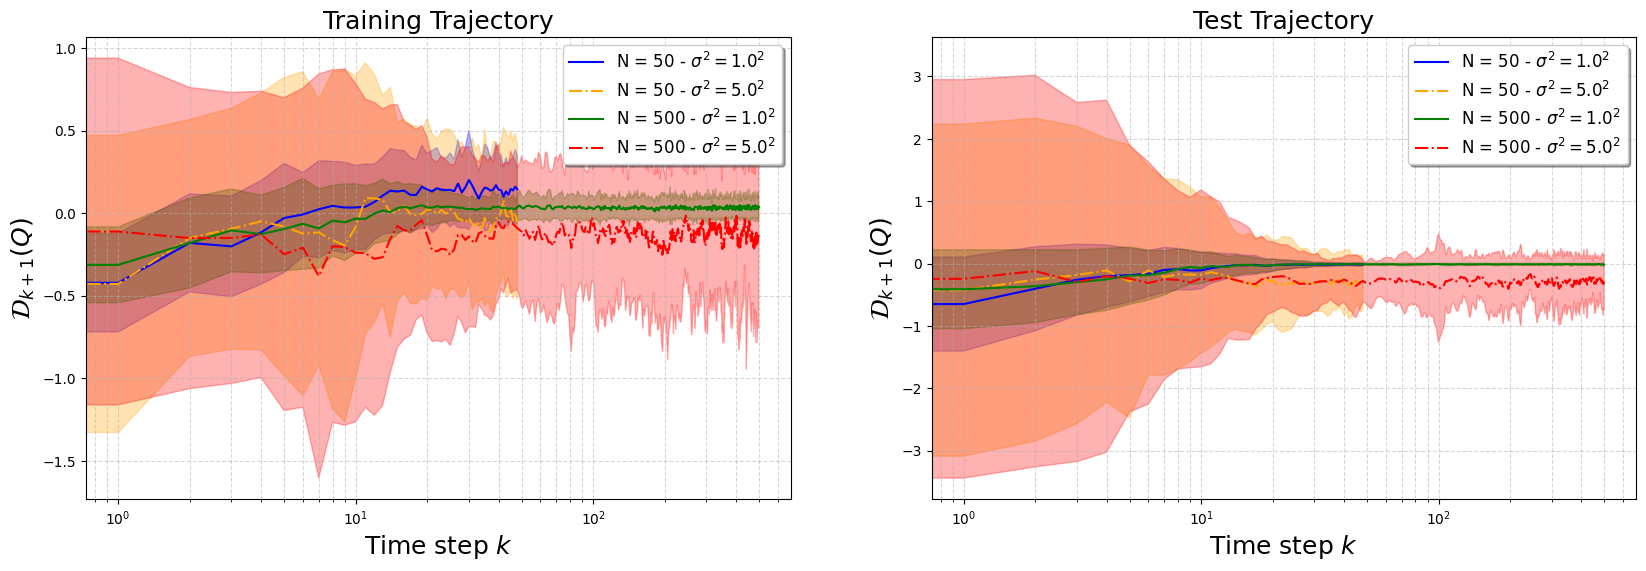

In [163]:
linestyles = ["-","-."] 
color = [["blue", "orange"], ["green", "red"]]
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 6))

for i, n_step in enumerate(N_step):
    for j, var in enumerate(vars):

        TDs_train = temporal_differences_train[(n_step, var)]
        TDs_test = temporal_differences_test[(n_step, var)]

        TD_train_mean = np.mean(TDs_train, axis = 0)
        TD_train_std = np.std(TDs_train, axis = 0)

        TD_test_mean = np.mean(TDs_test, axis = 0)
        TD_test_std = np.std(TDs_test, axis = 0)

        ax1.semilogx(TD_train_mean, linestyle=linestyles[j], label='N = ' + str(n_step) + f' - $\sigma^2 = {str(var)}^2$', color = color[i][j])
        ax1.fill_between(range(n_step-1), TD_train_mean - TD_train_std, TD_train_mean + TD_train_std, alpha=0.3, edgecolor = "k", color = color[i][j])

        ax2.semilogx(TD_test_mean, linestyle=linestyles[j], label='N = ' + str(n_step) + f' - $\sigma^2 = {str(var)}^2$', color = color[i][j])
        ax2.fill_between(range(n_step-1), TD_test_mean - TD_test_std, TD_test_mean + TD_test_std, alpha=0.3, edgecolor = "k", color = color[i][j])


ax1.set_xlabel(r'Time step $k$', fontsize = 18); ax2.set_xlabel(r'Time step $k$', fontsize = 18)
ax1.set_title("Training Trajectory", fontsize=18); ax2.set_title("Test Trajectory", fontsize=18)
ax1.set_ylabel('$\\mathcal{D}_{k+1}(Q)$', fontsize=18); ax2.set_ylabel('$\\mathcal{D}_{k+1}(Q)$', fontsize=18)
ax1.grid(linestyle='--', alpha=0.5, which="both") ; ax2.grid(linestyle='--', alpha=0.5, which="both")
ax1.legend(shadow=True, fancybox=True, fontsize=12, loc='upper right'); ax2.legend(shadow=True, fancybox=True, fontsize=12, loc='upper right')
plt.savefig("figures/temp_diff_noise.pdf", dpi=300)
plt.show()

## 6. LSTD + PI

In [16]:
n_step = 100
x0 = [0, 2, 2, 2, 5]
phi = LQR_policy
psi = psi_Q
d = 10
W = 1 * np.eye(d)
bounds_u = (-20, 20) # bounds for the action space

### 6.1. Temporal Differences

KeyboardInterrupt: 

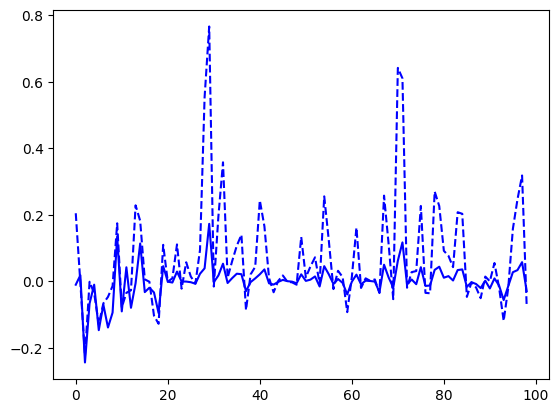

In [10]:
x0_conditions = [[0, 2, 2, 0, 1], [1, 2, 4, 0, 2], [5, 0, 2, 2, 0]]
colors = ['b', 'g', 'r']
linestyles = ['-', '--']

for i, x0_i in enumerate(x0_conditions):
    data_nl = simulate_nl_model(x0_i, phi_e, n_step, with_noise=False)

    theta_lstd = perform_lstd(phi, cost, psi, W, data_nl, d)
    theta_lstd_PI = perform_lstd_PI(phi, cost, psi, W, data_nl, n_iter=1000, action_space = bounds_u, d=d)

    def policy_lstd_PI(x: np.ndarray) -> np.ndarray:
        return policy_Q(x, theta_lstd_PI)
    
    temporal_differences_PI = compute_TD(data_nl, Q_lstd, policy_lstd_PI, cost, psi, theta_lstd_PI)
    temporal_differences_LSTD = compute_TD(data_nl, Q_lstd, LQR_policy, cost, psi, theta_lstd)


    plt.plot(temporal_differences_PI, label='x0 = ' + str(x0_i) + ' - PI + LSTD', color = colors[i], linestyle = linestyles[0])
    plt.plot(temporal_differences_LSTD, label='x0 = ' + str(x0_i) + ' - LSTD', color = colors[i], linestyle = linestyles[1])

plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.savefig('figures/temp_diff_PI.pdf',dpi=300)
plt.show()

### 6.2. Trajectories with the new policy

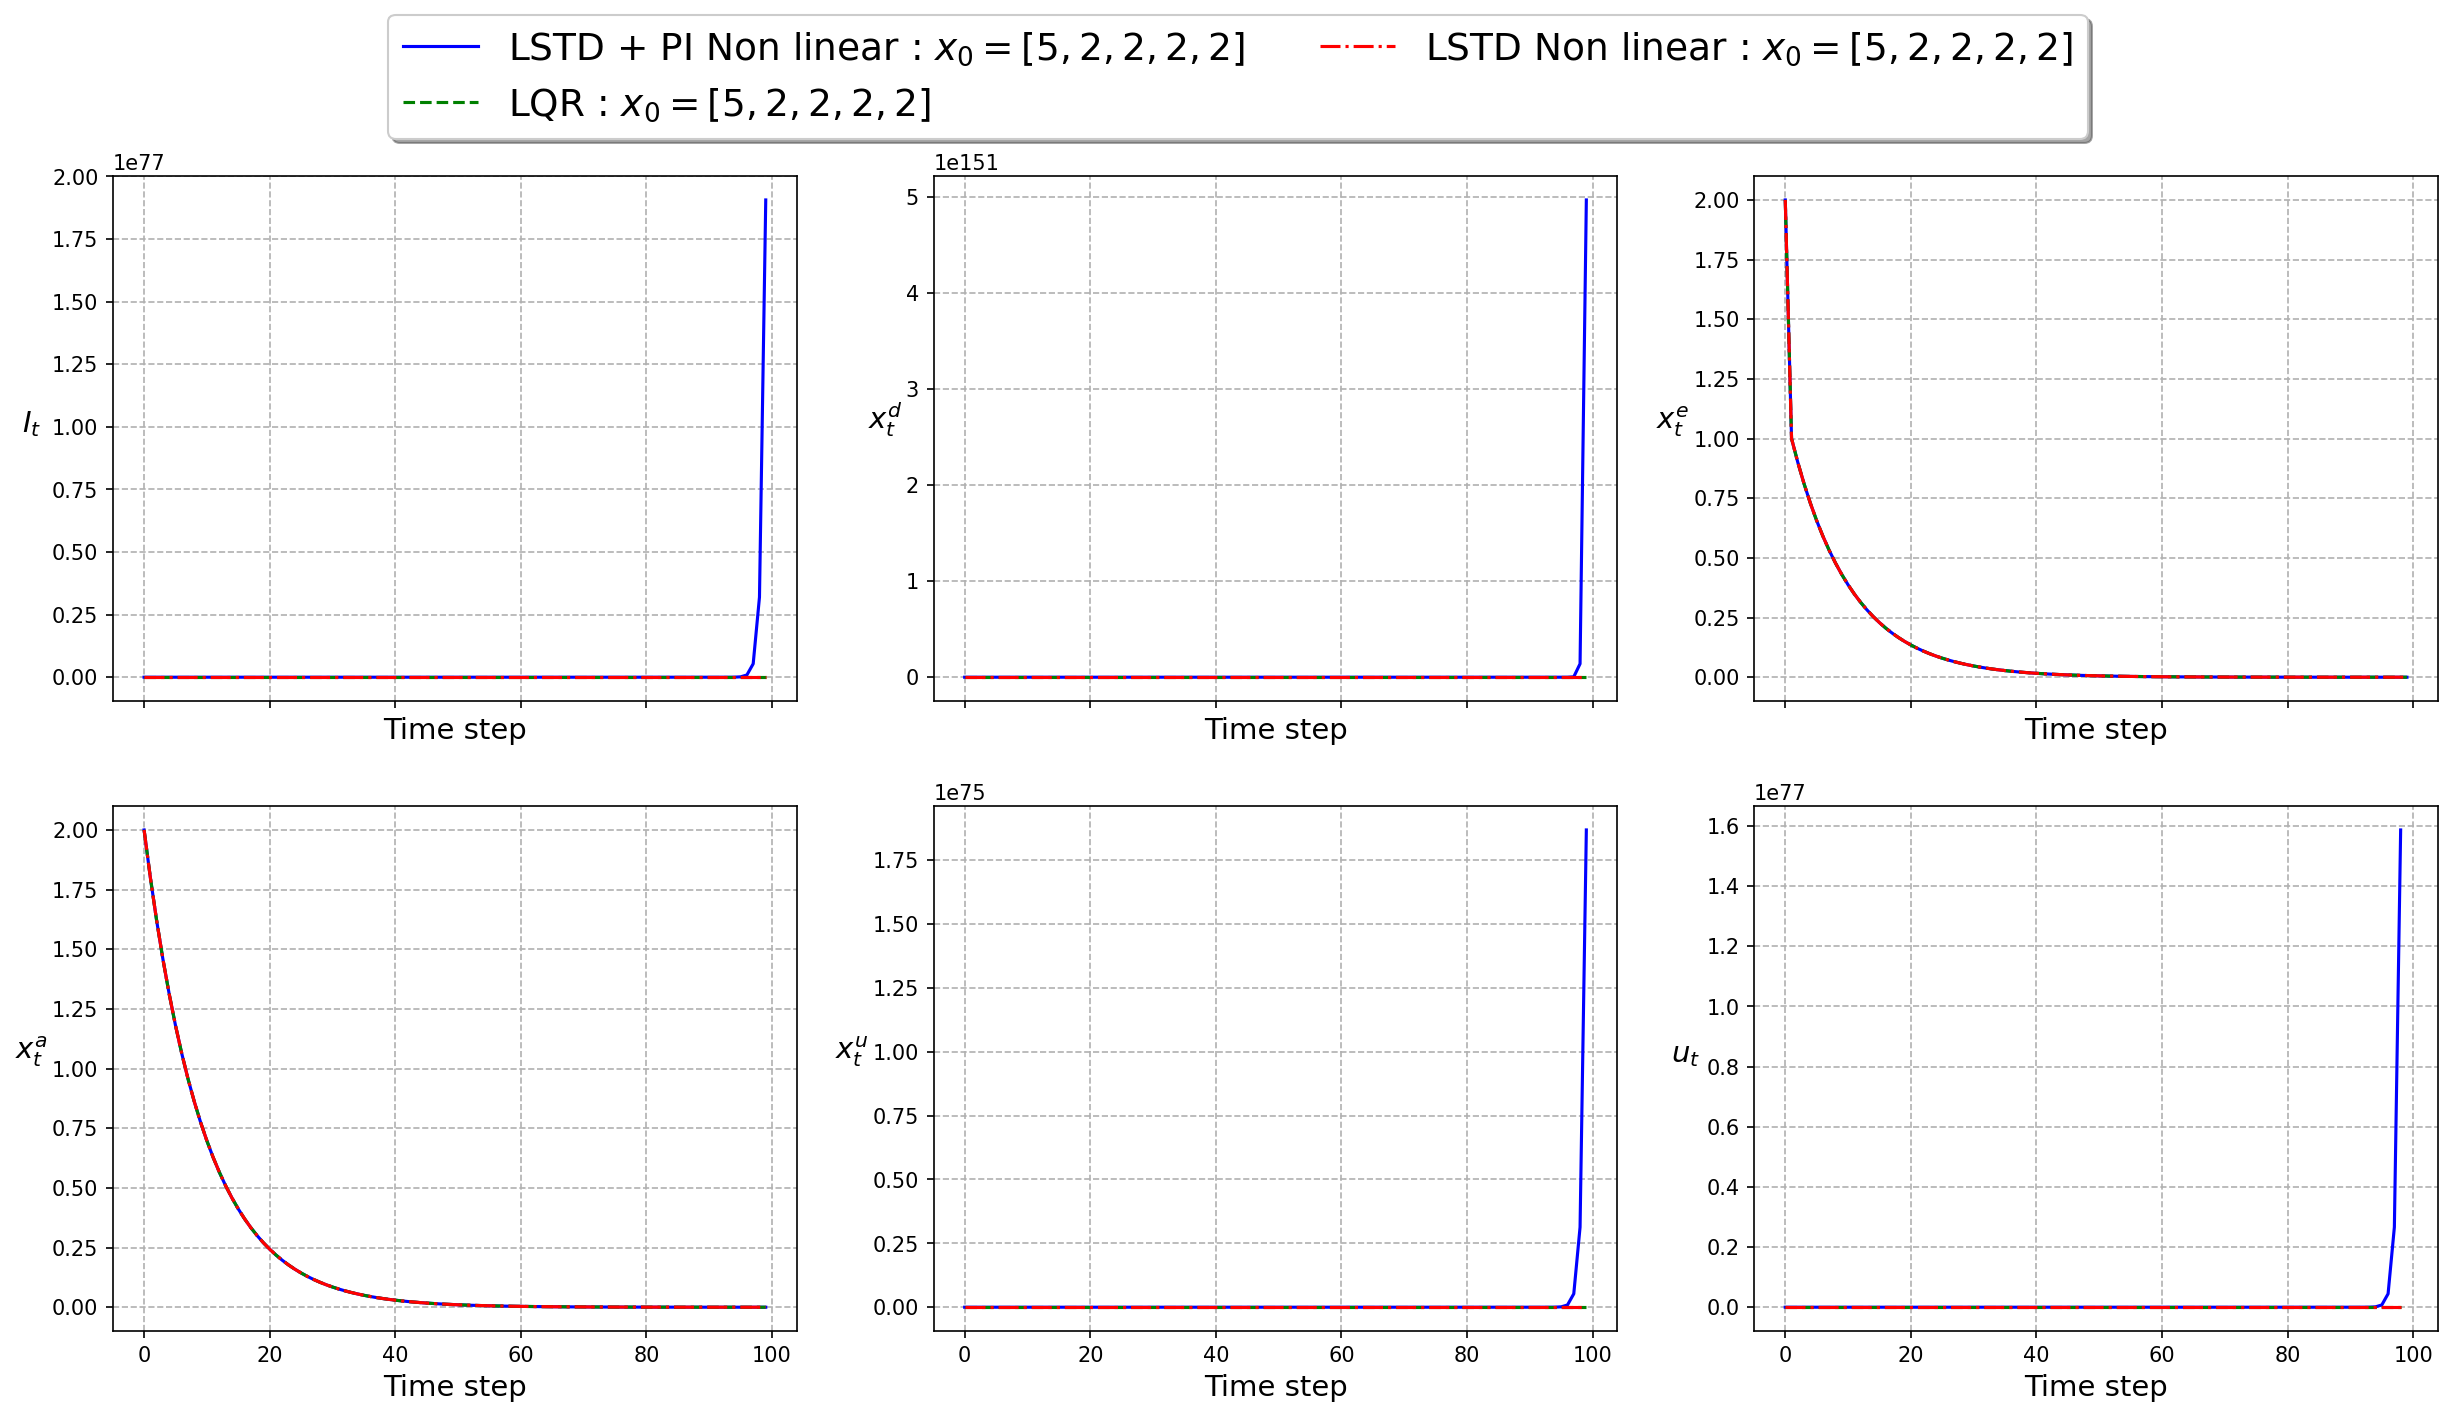

In [ ]:

data_nl = simulate_nl_model(x0, phi_e, n_step, with_noise=False)
data_linear = simulate_linear_model(x0, phi_e, n_step, with_noise=False)

theta_lstd_nl = perform_lstd(phi, cost, psi, W, data=data_nl, d=d)
theta_lstd_PI = perform_lstd_PI(phi, cost, psi, W, data_nl, n_iter=1000, action_space = bounds_u, d=d)

def policy_lstd_nl(x: np.ndarray) -> np.ndarray:
    return policy_Q(x, theta_lstd_nl)

def policy_lstd_PI(x: np.ndarray) -> np.ndarray:
    return policy_Q(x, theta_lstd_PI)

x0_test = [5, 2, 2, 2, 2]
x_lstd_PI, u_lstd_PI  = simulate_nl_model(x0_test, policy_lstd_PI, n_step, with_noise=False)
x_lstd, u_lstd = simulate_nl_model(x0_test, policy_lstd_nl, n_step, with_noise=False)
x_lqr, u_lqr = simulate_nl_model(x0_test, LQR_policy, n_step, with_noise=False)

show_trajectories([[x_lstd_PI], [x_lqr], [x_lstd]], [[u_lstd_PI], [u_lqr], [u_lstd]], [x0_test, x0_test, x0_test], ['LSTD + PI Non linear',"LQR", "LSTD Non linear"], save = "traj_lstd_PI_nl.pdf")

># Q($\lambda$) Learning Method

## 1. Analyzing the temporal differences for several parameters

In [167]:
def alpha_k(k, factor=1e-4):
    return factor / (k + 1)

In [168]:
nstep = 100
x0 = [0, 2, 2, 2, 5]
data_linear = simulate_linear_model(x0, phi_e, nstep, with_noise=False)
psi = psi_Q
d = 10
theta_lstd = perform_lstd(LQR_policy, cost, psi, W=np.eye(d), data=data_linear, d=d)
cost_fct = cost
theta0 = theta_lstd

phi = LQR_policy

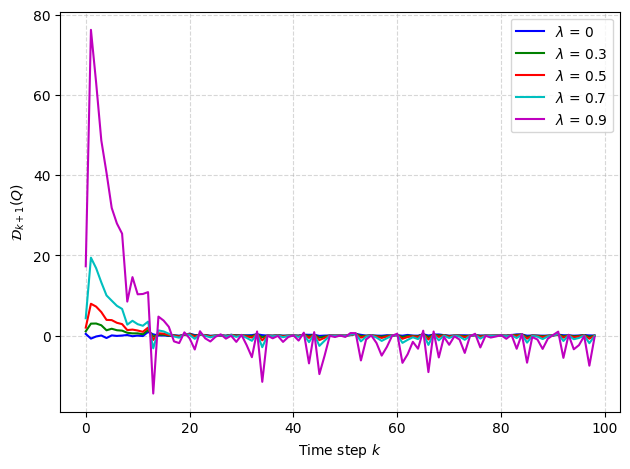

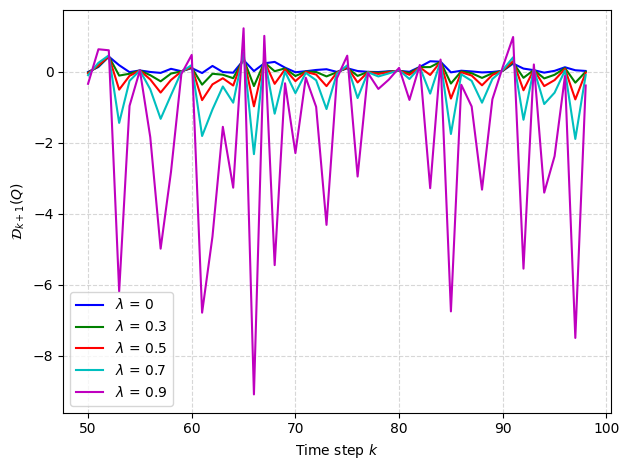

In [ ]:
## Temporal differences for several lambdas ###
lam = [0, 0.3, 0.5, 0.7, .9]
zeta0_vector = psi_Q
colors = ['b', 'g', 'r', 'c', 'm']
TD_all = []
factor = 1e-4

for i in range(len(lam)):
    theta_qlearn, zeta = q_learning(lam[i], data_linear, lambda k: alpha_k(k,factor), theta0, zeta0_vector, psi, cost_fct, bounds_u)

    def policy_qlearn(x: np.ndarray) -> np.ndarray:
        return policy_Q(x, theta_qlearn)

    TD = compute_TD(data_linear, Q_lstd, policy_qlearn, cost_fct, zeta, theta_qlearn)
    TD_all.append(TD)

for i in range(len(lam)):
    plt.plot(TD_all[i], label='$\lambda$ = ' + str(lam[i]), color = colors[i])

plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('figures/temp_diff_lambdaQlearn.pdf',dpi=300)
plt.show()

time = np.arange(50, nstep-1)
for i in range(len(lam)):
    plt.plot(time, TD_all[i][50:], label='$\lambda$ = ' + str(lam[i]), color = colors[i])


plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig('temp_diff_lambdaQlearn_zoom.pdf',dpi=300)
plt.show()

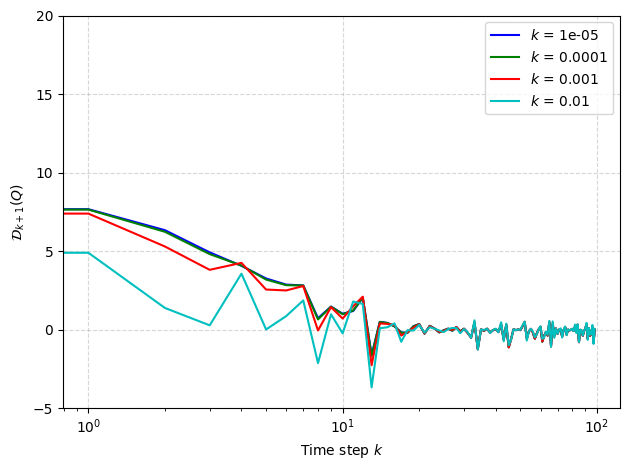

In [170]:
### TD for several alpha_k ###
factors = [1e-5, 1e-4, 1e-3, 1e-2]
TD_all = []
lam = 0.5
for i in range(len(factors)):
    theta_qlearn, zeta = q_learning(lam, data_linear, lambda k: alpha_k(k,factors[i]), theta0, zeta0_vector, psi, cost_fct, bounds_u)

    def policy_qlearn(x: np.ndarray) -> np.ndarray:
        return policy_Q(x, theta_qlearn)

    TD = compute_TD(data_linear, Q_lstd, policy_qlearn, cost_fct, zeta, theta_qlearn)
    TD_all.append(TD)
TD_all = np.array(TD_all)
for i in range(len(factors)):
    plt.plot(TD_all[i], label='$k$ = ' + str(factors[i]), color = colors[i])

plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
plt.xscale('log')
plt.ylim(-5,20)
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('figures/temp_diff_alphaQlearn.pdf',dpi=300)
plt.show()

## 2. Using Q($\lambda$)-learning to produce policies

In [171]:
def alpha_k(k: int) -> float:
    return 1e-2 / (k + 1)

In [172]:
nstep = 100
d = 10
x0 = [0, 2, 2, 2, 5]
data_linear = simulate_linear_model(x0, phi_e, nstep, with_noise=False)


psi = psi_Q
theta0 = perform_lstd(LQR_policy, cost, psi, W=np.eye(d), data=data_linear, d=d)

In [173]:
lambdas = [0, 0.5, .9]
data_qlearn = {}
x_test = [5, 0, 0, 0, 0]

for lam in lambdas:
    zeta0_vector = psi_Q # initial zeta is zero apart from the u**2 term
    theta_qlearn, zeta = q_learning(lam, data_linear, alpha_k, theta0.copy(), zeta0_vector, psi, cost, bounds_u)
    policy_qlearn = lambda x: policy_Q(x, theta_qlearn)
    
    x_qlearn, u_qlearn = simulate_linear_model(x0_test, policy_qlearn, nstep, with_noise=False)
    data_qlearn[lam] = (x_qlearn, u_qlearn)

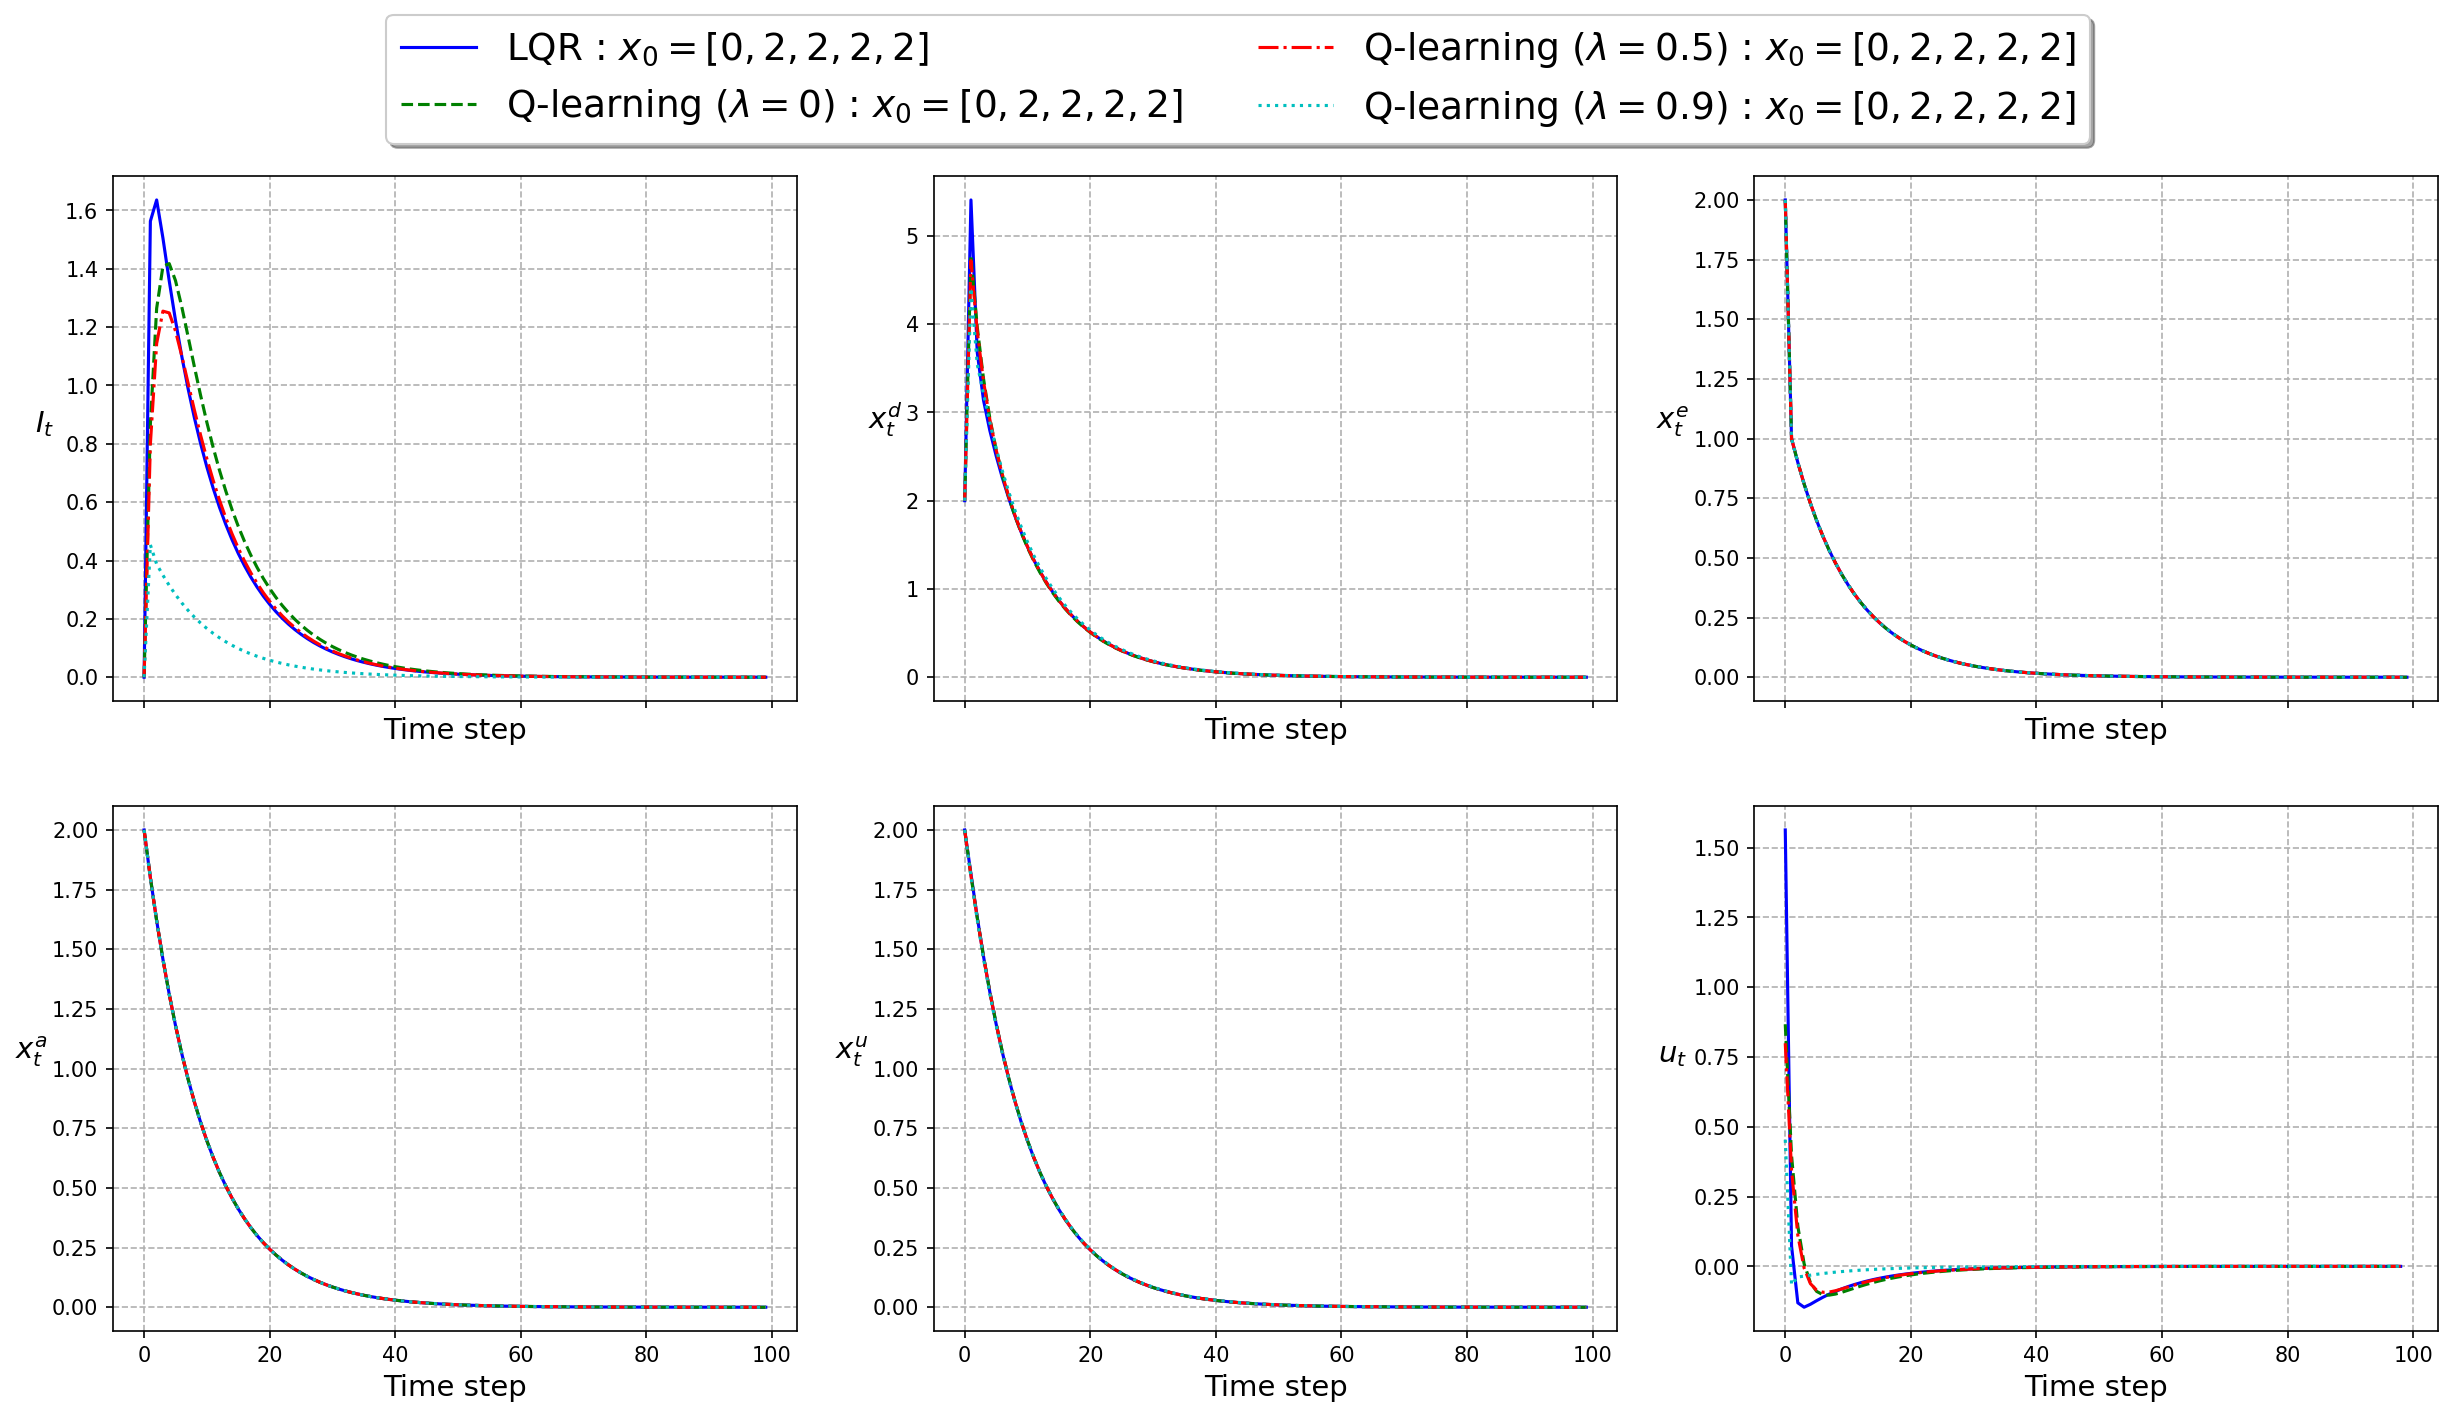

In [174]:
x_lqr, u_lqr = simulate_linear_model(x0_test, LQR_policy, nstep, with_noise=False)
show_trajectories( [[x_lqr]] + [[x] for (x, u) in data_qlearn.values()], [[u_lqr]] + [[u] for (x, u) in data_qlearn.values()], [x0_test for _ in data_qlearn.keys()] + [x0_test],["LQR"] +[rf'Q-learning ($\lambda = {lam}$)' for lam in lambdas], save = "Qlearning_lambda")